In [67]:
import torch, torch.utils.data
from torch import nn
import torchvision, torchvision.datasets
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List


import sys
sys.path.append('./datasets/')
from datasets.dataloader import get_LEAF_dataloader

from torch.profiler import profile, record_function, ProfilerActivity
import time
from sklearn.metrics import f1_score   
import numpy as np
    


In [68]:
print(torch.__version__)




2.0.0


In [69]:

train_loaders = []
test_loaders = []
num_nodes = 5
num_class = 10
epoch_total = 10
pickle_name = "mnist-epoch-"+str(epoch_total)

In [70]:
device = torch.device('cuda')
torch.cuda.get_device_name(device)

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [71]:

transform = transforms.Compose([
    transforms.ToTensor(),
])
target_transform = lambda x: torch.nn.functional.one_hot(torch.tensor(x),num_class).float()

In [72]:
# def split_dataset(dataset, n):
#     torch.utils.data.random_split(dataset, )

In [73]:
# train_dataset2 = torchvision.datasets.MNIST('datasets/', download=True, train=True, transform=transform, target_transform=target_transform),
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000000, num_workers=0)

# test_dataset = torchvision.datasets.MNIST('datasets/', download=True, train=False, transform=transform, target_transform=target_transform)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000000, num_workers=0)


# Inital MNIST
train_datasets = torch.utils.data.random_split(torchvision.datasets.MNIST('datasets/',
                                                                           download=True, train=True, transform=transform, target_transform=target_transform), [1/num_nodes]*num_nodes)
test_datasets = torch.utils.data.random_split(torchvision.datasets.MNIST('datasets/',
                                                                           download=True, train=False, transform=transform, target_transform=target_transform), [1/num_nodes]*num_nodes)

train_loaders = [torch.utils.data.DataLoader(i, batch_size=1000000, num_workers=0) for i in train_datasets]
test_loaders = [torch.utils.data.DataLoader(i, batch_size=1000000, num_workers=0) for i in test_datasets]


In [74]:
print(len(train_loaders))
print(len(test_loaders))
print(test_loaders)
print(len(test_loaders[0].dataset))

5
5
[<torch.utils.data.dataloader.DataLoader object at 0x7f8054a1b3a0>, <torch.utils.data.dataloader.DataLoader object at 0x7f8055a63c70>, <torch.utils.data.dataloader.DataLoader object at 0x7f8050210b20>, <torch.utils.data.dataloader.DataLoader object at 0x7f8050211360>, <torch.utils.data.dataloader.DataLoader object at 0x7f8050212b90>]
2000


In [75]:

x_i_j = {}
s_i = {}

ypred = []
ylabels = []

In [76]:
class FederatedNode:
    def __init__(self, train_dataloader, test_dataloader, node_id) -> None:
        self.dataset_size = len(train_dataloader.dataset)
        channels_sum, channels_squared_sum, num_batches = 0, 0, 0
        for data, _ in train_dataloader:
            # Mean over batch, height and width, but not over the channels
            channels_sum += torch.mean(data, dim=[0])
            channels_squared_sum += torch.mean(data**2, dim=[0])
            num_batches += 1
    
        self.mean = channels_sum / num_batches
        self.test_loss = 0.0
        self.test_accuracy = 0.0
        self.train_accuracy = 0.0
        self.train_loss = 0.0
        self.f1_score = 0.0


        # std = sqrt(E[X^2] - (E[X])^2)
        self.std = (channels_squared_sum / num_batches - self.mean ** 2) ** 0.5
        print("Dataset size ", self.dataset_size)
        print("Mean size ", self.mean.shape)
        print("Standard deviation size ", self.std.shape)
        
        
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784,56),
            nn.ReLU(),
            nn.Linear(56, 10)
        ).to(device)

        '''
        only_digits=False
        self.network = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(9216, 128),
        nn.Dropout(0.5),
        nn.Linear(128, 10 if only_digits else 62),
        nn.ReLU()
        ).to(device)
        '''
        self.optimizer = torch.optim.Adam(self.network.parameters())
        self.criterion = nn.CrossEntropyLoss()
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.node_id = node_id
    
    def train_epoch(self):
        losses = []
        correct = 0
        total = 0
        for idx, (data_x, data_y) in enumerate(self.train_dataloader):
            #print("data_x", data_x.shape)
            #print("data_y", data_y.shape)
            #plt.imshow(data_x[1][0])
            output = self.network(data_x.to(device))
            self.optimizer.zero_grad()
            #print(output.shape)
            #print(data_y)
            #data_y = target_transform(data_y)
            
            #loss = nn.functional.mse_loss(output, data_y.to(device))
            loss = self.criterion(output, data_y.to(device))
            losses.append(loss.item())
            loss.backward()
            self.optimizer.step()

            _, predicted = torch.max(output.data, 1)
            data_y = data_y.to(predicted.device)
            true_labels = torch.argmax(data_y, dim=1).to(predicted.device)
            total += data_y.size(0)
            correct += (predicted == true_labels).sum().item()
            ypred.append(data_y)
            ylabels.append(true_labels)
        self.train_accuracy = correct/total
        print("DEBUG:",self.node_id, self.train_accuracy, correct, total)
        self.train_loss = sum(losses)/len(losses)
        return self.train_accuracy, self.train_loss
    
    def testing(self):
        correct = 0
        total = 0
        # test_running_loss = 0.0
        predictions = []
        labels = []
        test_running_losses = []
        for idx, (data_x, data_y) in enumerate(self.test_dataloader):
            output = self.network(data_x.to(device))
            
            _, predicted = torch.max(output.data, 1)
            data_y = data_y.to(predicted.device)
            true_labels = torch.argmax(data_y, dim=1).to(predicted.device)
            total += data_y.size(0)
            correct += (predicted == true_labels).sum().item()
            
            loss = self.criterion(output, data_y)
            predictions.append(predicted.cpu())
            #labels.append(data_y.cpu())
            labels.append(true_labels.cpu())
            test_running_losses.append(loss.item())
            #print('Epoch %d test loss: %.3f' % (idx + 1, test_running_losses[-1]))
            #print(test_running_losses)
            #test_running_loss += loss.item()
            #test_loss.append(test_running_loss / len(self.test_dataloader))
        
        #print(predictions)
        predictions = np.concatenate(predictions)
        labels = np.concatenate(labels)
        self.f1_score= f1_score(labels, predictions, average="weighted")
        self.test_accuracy = correct/total
        #print(self.test_accuracy)
        self.test_loss =  sum(test_running_losses)/len(test_running_losses)
        #print("test loss ",self.test_loss)
       
    
    def share_x_ij(self):
        x = self.network.state_dict()
        r = torch.randint(1, 5, [num_nodes])
        s_r = torch.sum(r)
        j=self.node_id
        for i in range(num_nodes):
            x_i_j[(i,j)]={}
            for key in x.keys():
                x_i_j[(i,j)][key]=x[key]*r[i]/s_r
    
    def share_s_i(self):
        i = self.node_id
        s_i[i] = {}
        for key in x_i_j[(0,0)].keys():
            s_i[i][key] = sum([x_i_j[(i,j)][key] for j in range(num_nodes)])
    







In [81]:
#for i, loader_data in enumerate(zip(*loader)):
#    train_loaders, test_loaders = loader_data

nodes = []
for i in range(num_nodes):
    nodes.append(FederatedNode(train_loaders[i], test_loaders[i], i)) 

#nodes = [FederatedNode(l, i) for i,l in enumerate())]

Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])


In [82]:
losses = []
train_accuracies = []
test_accuracies = []
test_losses = []
f1_scores = []
#with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
#    with record_function("model_training"):

start_time = time.time()
for i in tqdm(range(epoch_total)):
    epoch_losses = []
    epoch_acc = []
    for node in nodes:
        tarin_acc, loss = node.train_epoch()
        epoch_acc.append(tarin_acc)
        epoch_losses.append(loss)
    train_accuracies.append(epoch_acc)
    losses.append(epoch_losses)


    
    epoch_test_accuracies = []
    epoch_test_losses = []
    epoch_f1_scores = []
    for i, node in enumerate(nodes):
        #print()
        #print("Node ", i)
        
        node.testing()
        #test_losses.append(node.test_loss)
        #print("Node Test Accuracy", node.test_accuracy)
        #print("Node Test loss", node.test_loss)
        #print("Node F1_Score ", node.f1_score)
        epoch_test_accuracies.append(node.test_accuracy)
        epoch_test_losses.append(node.test_loss)
        epoch_f1_scores.append(node.f1_score)
            
    test_accuracies.append(epoch_test_accuracies)
    test_losses.append(epoch_test_losses)
    f1_scores.append(epoch_f1_scores)

    x_i_j = {}
    s_i = {}
    for node in nodes:
        node.share_x_ij()
    
    for node in nodes:
        node.share_s_i()
    
    #av_state = {}
    #print(s_i[0])
    #for key in s_i[0].keys():
    #    av_state[key]=torch.mean(torch.tensor([s_i[i][key] for i in s_i]), dim=[0])
    averaged_state = {}
    for key in s_i[0].keys():
        param_value = 0
        for i in s_i:
            param_value += s_i[i][key]
        
        averaged_state[key] = param_value/num_nodes

    for node in nodes:
        node.network.load_state_dict(averaged_state)

    
    
    
    # states = [i.network.state_dict() for i in nodes]
    # av_state = {}
    # for key in states[0]:
    #     av_state[key] = sum([s[key] for s in states])/num_nodes
    # for node in nodes:
    #     node.network.load_state_dict(av_state)

time_FL_SMPC = time.time() - start_time

print("Time taken by FL with SMPC", time_FL_SMPC)
    


  0%|          | 0/10 [00:00<?, ?it/s]

DEBUG: 0 0.10525 1263 12000
DEBUG: 1 0.0685 822 12000
DEBUG: 2 0.09583333333333334 1150 12000
DEBUG: 3 0.09283333333333334 1114 12000
DEBUG: 4 0.07641666666666666 917 12000


 10%|█         | 1/10 [00:13<02:02, 13.57s/it]


KeyboardInterrupt: 

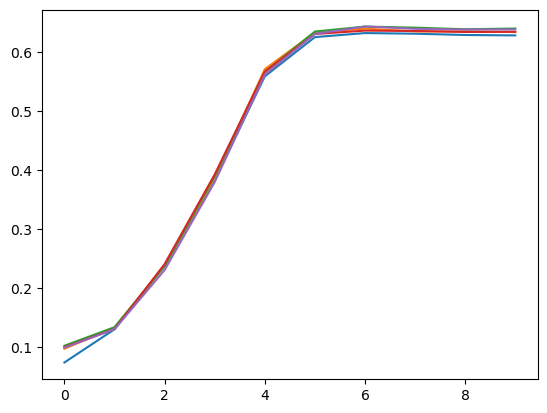

In [ ]:
plt.plot(train_accuracies)

In [ ]:
import pickle

try:
    my_pickle_results = pickle.load( open( pickle_name+'.pickle', "rb" ) )
    result = {}
    result2 = {}
    myResults = my_pickle_results
except (OSError, IOError) as e:
    my_pickle_results = {}
    result = {}
    result2 = {}

In [ ]:
result["train_accuracies"] = train_accuracies
result["train_losses"] = losses
result["test_accuracies"] = test_accuracies
result["test_losses"] = test_losses
result["f1_scores"] = f1_scores
result["ypred"] = ypred
result["ylabels"] = ylabels
result["time_taken"] = time_FL_SMPC


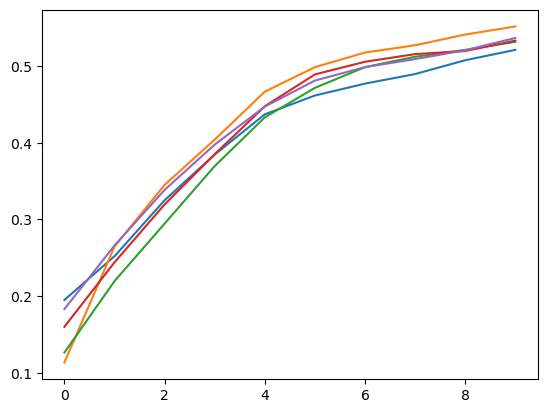

In [ ]:
plt.plot(test_accuracies)

In [ ]:
print(losses)

[[2.3160862922668457, 2.3047897815704346, 2.31680965423584, 2.3065083026885986, 2.312915086746216], [2.2957732677459717, 2.295050621032715, 2.2950446605682373, 2.29567813873291, 2.2949047088623047], [2.284480094909668, 2.283694267272949, 2.283641815185547, 2.2843992710113525, 2.283486843109131], [2.2698538303375244, 2.269014835357666, 2.268907070159912, 2.2699151039123535, 2.2687344551086426], [2.252500057220459, 2.251540422439575, 2.2513978481292725, 2.2527339458465576, 2.2511494159698486], [2.233109712600708, 2.2319343090057373, 2.231781005859375, 2.2334401607513428, 2.2314131259918213], [2.2118804454803467, 2.2104570865631104, 2.2102859020233154, 2.212301731109619, 2.2098004817962646], [2.1891164779663086, 2.187377691268921, 2.187201738357544, 2.1895949840545654, 2.186598777770996], [2.164997100830078, 2.162914752960205, 2.162733316421509, 2.165524959564209, 2.1620121002197266], [2.1396896839141846, 2.1372392177581787, 2.1370673179626465, 2.1402556896209717, 2.136221408843994]]


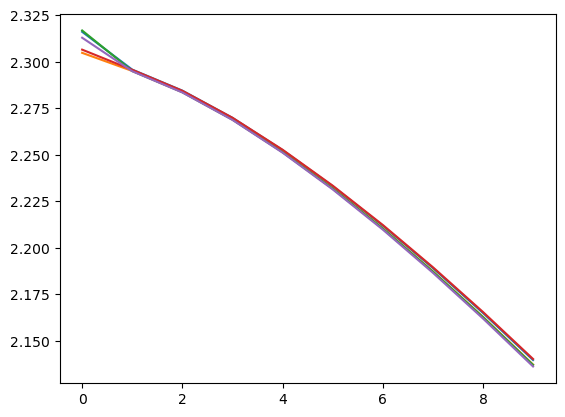

In [ ]:
plt.plot(losses)

In [102]:

nodes = []
for i in range(num_nodes):
    nodes.append(FederatedNode(train_loaders[i], test_loaders[i], i)) 


Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])


In [103]:
losses = []
train_accuracies = []
test_accuracies = []
test_losses = []
f1_scores = []

start_time = time.time()
for i in tqdm(range(epoch_total)):
    epoch_losses = []
    epoch_acc =[]
    for node in nodes:
        tarin_acc, loss = node.train_epoch()
        epoch_acc.append(tarin_acc)
        epoch_losses.append(loss)
    train_accuracies.append(epoch_acc)
    losses.append(epoch_losses)


    
    epoch_test_accuracies = []
    epoch_test_losses = []
    epoch_f1_scores = []
    for i, node in enumerate(nodes):

        node.testing()
        epoch_test_accuracies.append(node.test_accuracy)
        epoch_test_losses.append(node.test_loss)
        epoch_f1_scores.append(node.f1_score)
            
    test_accuracies.append(epoch_test_accuracies)
    test_losses.append(epoch_test_losses)
    f1_scores.append(epoch_f1_scores)
    
    av_state = {}
    
    
    
    states = [i.network.state_dict() for i in nodes]
    av_state = {}
    for key in states[0]:
        av_state[key] = sum([s[key] for s in states])/num_nodes
    for node in nodes:
        node.network.load_state_dict(av_state)

time_FL = time.time() - start_time

print("Time taken by FL without SMPC", time_FL)
    

  0%|          | 0/10 [00:00<?, ?it/s]

DEBUG: 0 0.076 912 12000
DEBUG: 1 0.06258333333333334 751 12000
DEBUG: 2 0.13325 1599 12000
DEBUG: 3 0.11125 1335 12000
DEBUG: 4 0.14391666666666666 1727 12000


 10%|█         | 1/10 [00:09<01:25,  9.48s/it]

DEBUG: 0 0.10608333333333334 1273 12000
DEBUG: 1 0.11233333333333333 1348 12000
DEBUG: 2 0.112 1344 12000
DEBUG: 3 0.11425 1371 12000
DEBUG: 4 0.11925 1431 12000


 20%|██        | 2/10 [00:19<01:17,  9.67s/it]

DEBUG: 0 0.18775 2253 12000
DEBUG: 1 0.19675 2361 12000
DEBUG: 2 0.19075 2289 12000
DEBUG: 3 0.19375 2325 12000
DEBUG: 4 0.206 2472 12000


 30%|███       | 3/10 [00:29<01:07,  9.70s/it]

DEBUG: 0 0.28391666666666665 3407 12000
DEBUG: 1 0.28775 3453 12000
DEBUG: 2 0.29108333333333336 3493 12000
DEBUG: 3 0.28983333333333333 3478 12000
DEBUG: 4 0.29425 3531 12000


 40%|████      | 4/10 [00:38<00:57,  9.60s/it]

DEBUG: 0 0.35025 4203 12000
DEBUG: 1 0.35241666666666666 4229 12000
DEBUG: 2 0.35683333333333334 4282 12000
DEBUG: 3 0.3585 4302 12000
DEBUG: 4 0.35775 4293 12000


 50%|█████     | 5/10 [00:48<00:48,  9.63s/it]

DEBUG: 0 0.38966666666666666 4676 12000
DEBUG: 1 0.39125 4695 12000
DEBUG: 2 0.39641666666666664 4757 12000
DEBUG: 3 0.39925 4791 12000
DEBUG: 4 0.39641666666666664 4757 12000


 60%|██████    | 6/10 [00:57<00:38,  9.56s/it]

DEBUG: 0 0.4191666666666667 5030 12000
DEBUG: 1 0.42175 5061 12000
DEBUG: 2 0.42141666666666666 5057 12000
DEBUG: 3 0.42633333333333334 5116 12000
DEBUG: 4 0.4221666666666667 5066 12000


 70%|███████   | 7/10 [01:07<00:28,  9.52s/it]

DEBUG: 0 0.43925 5271 12000
DEBUG: 1 0.44408333333333333 5329 12000
DEBUG: 2 0.44266666666666665 5312 12000
DEBUG: 3 0.44858333333333333 5383 12000
DEBUG: 4 0.44425 5331 12000


 80%|████████  | 8/10 [01:16<00:19,  9.52s/it]

DEBUG: 0 0.4598333333333333 5518 12000
DEBUG: 1 0.46458333333333335 5575 12000
DEBUG: 2 0.4638333333333333 5566 12000
DEBUG: 3 0.466 5592 12000
DEBUG: 4 0.4655 5586 12000


 90%|█████████ | 9/10 [01:25<00:09,  9.39s/it]

DEBUG: 0 0.48083333333333333 5770 12000
DEBUG: 1 0.485 5820 12000
DEBUG: 2 0.4845833333333333 5815 12000
DEBUG: 3 0.4861666666666667 5834 12000
DEBUG: 4 0.48733333333333334 5848 12000


100%|██████████| 10/10 [01:34<00:00,  9.49s/it]

Time taken by FL without SMPC 94.89722108840942


In [104]:
train_accuracies[0]

[0.076, 0.06258333333333334, 0.13325, 0.11125, 0.14391666666666666]

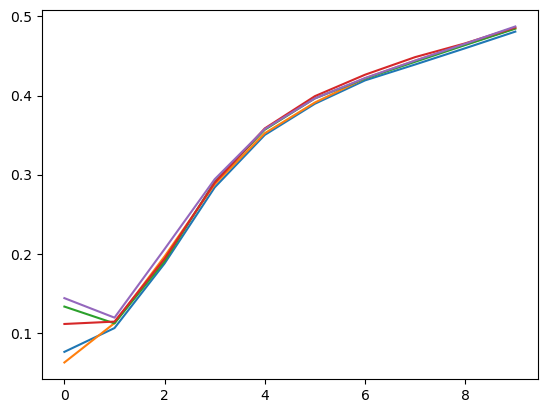

In [105]:
plt.plot(train_accuracies)

In [106]:
#print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

In [107]:
global_mean = 0.0
global_std = 0.0
eqn1= 0.0 
eqn2 = 0.0
eqn3 = 0.0
for node in nodes:
    eqn1 += node.mean * node.dataset_size
    eqn2 += node.dataset_size 
    eqn3 += node.std


global_mean = eqn1/eqn2
global_std = eqn3/eqn2
print("Global Mean", global_mean.shape)
print("Global std ", global_std.shape)
#plt.imshow(global_mean.squeeze())
#plt.imshow(global_std.squeeze())

Global Mean torch.Size([1, 28, 28])
Global std  torch.Size([1, 28, 28])


In [108]:
result2["train_accuracies"] = train_accuracies
result2["train_losses"] = losses
result2["test_accuracies"] = test_accuracies
result2["test_losses"] = test_losses
result2["f1_scores"] = f1_scores
result2["ypred"] = ypred
result2["ylabels"] = ylabels
result2["time_taken"] = time_FL


In [109]:
my_pickle_results["vanilla"] = result2
#print(my_pickle_results)
# pickle.dumps(my_pickle_results)
print(my_pickle_results["vanilla"]["time_taken"])

94.89722108840942


In [110]:
with open(pickle_name+'.pickle', 'wb') as handle:
    pickle.dump(my_pickle_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [111]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
labels = []
for _, label in train_loaders[0]:
    labels.append(label)
print(labels)
#print(classification_report(y_true, y_pred, target_names=target_names))

[tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])]


In [112]:
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2023-05-13 22:12:42


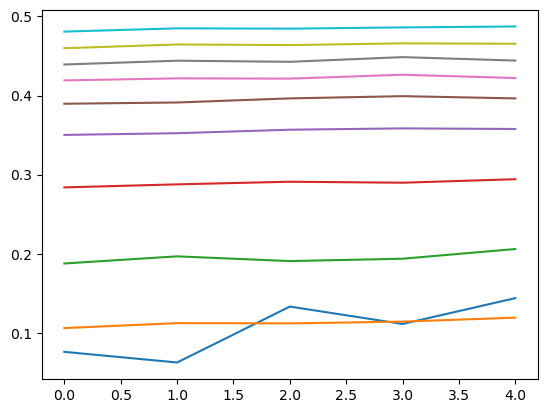

In [113]:
plt.plot(np.array(train_accuracies).T)